In [1]:
#!pip install gmusicapi
from gmusicapi import Mobileclient,Webclient,Musicmanager
from gmusicapi.utils import utils
print (utils.log_filepath)
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import keras as ks
from matplotlib import pyplot as plt
%matplotlib inline
import requests
import gensim
# !pip install tqdm
from tqdm import tqdm_notebook as tqdm
import sklearn as sk

import sklearn.preprocessing
import sklearn.ensemble

from sklearn import neural_network

import json

/Users/aduriseti/Library/Logs/gmusicapi/gmusicapi.log


Using TensorFlow backend.


In [2]:
# email = 'aduriseti@gmail.com'

# # # w/o 2fa
# # with open('pswd.txt') as pswdfile:
# #     pswd = "".join(pswdfile.read().split())
# # w/ 2fa
# pswd = 'ehshpxjlzaaoknix'

# # api = Webclient()
# # api.login('aduriseti@gmail.com', pswd)
# # # => True

# # api = Mobileclient()
# # api.login('aduriseti@gmail.com',pswd,api.FROM_MAC_ADDRESS)

# # api = Mobileclient()
# # api.login('aduriseti@gmail.com',pswd,'1234567890abcdef')

# api = Mobileclient()
# # api.logout()
# api.login(email,pswd,'ios736804AE-FC53-4256-B0A8-AE6654382D33')
# # api.login('aduriseti@gmail.com',pswd,'ios59025538-078C-430D-B894-458DC03ED2F3')
# # api.login('aduriseti@gmail.com',pswd,'iosCA0EA169-C6CA-4C54-9EF1-402D90F7C204')
# # test gpsoauth
# # gpsoauth.perform_master_login('aduriseti@gmail.com',pswd,'iosCA0EA169-C6CA-4C54-9EF1-402D90F7C204')

In [3]:
email = 'aduriseti@gmail.com'
pswd = 'ehshpxjlzaaoknix'

api = Mobileclient(debug_logging=False)
api.login(email,pswd,api.FROM_MAC_ADDRESS)
testsongid = api.get_all_songs()[0]['id']
# api.get_stream_url(testsongid)

for device in api.get_registered_devices():
    api.logout()
    api.login(email,pswd,device['id'].replace(':',''))
    try:
        api.get_stream_url(testsongid)
        print('DEVICE',device['id'],'AUTHORIZED')
        break
    except:
        print('DEVICE',device['id'],'NOT AUTHORIZED')

DEVICE ios:736804AE-FC53-4256-B0A8-AE6654382D33 NOT AUTHORIZED
DEVICE ios:59025538-078C-430D-B894-458DC03ED2F3 NOT AUTHORIZED
DEVICE ios:CA0EA169-C6CA-4C54-9EF1-402D90F7C204 NOT AUTHORIZED


In [4]:
for track in api.get_all_songs():
    try:
        api.get_stream_url(track['id'])
        print(track['title'])
    except:
        continue
# api.get_stream_url(track['id'])

### TODO
- [ ] create issue about getting songs in thumbs up but not in library
    - [ ] get_playlist_songs for auto playlist is always returning [] #99
    - [ ] generate auto playlist https://gist.github.com/simon-weber/5007769
    - [ ] Getting the auto-generated playlists using MobileClient #200
- [ ] fix issue about logging gpsoauth behavior - log unexpected responses from gpsoauth #532
- [ ] create issue about no valid apple id being able to generate streaming urls

#### Approach
- [ ] sample stations to create 'sentences' - get duplicates
- [ ] create song embeddings from song corpus
- [ ] predict genre from song embedding
- [ ] get song audio
- [ ] display song audio
- [ ] stream song audio
- [ ] get spectrogram from songs
- [ ] predict song embedding / song genre from 
    - [ ] (cnn/cnn w/ attention (heirarchical?)
    - [ ] (LSTM/GRU/RNN w/ attention)

In [5]:
# get all songs associated with account
songs = api.get_all_songs()
playlists = api.get_all_playlists()
playlist_content = api.get_all_user_playlist_contents()
stations = api.get_all_stations()
allsongs_name = 'allsongs'
allsongs_id = ([None]+[p['id'] for p in playlists if p['name'] == allsongs_name])[0]
ids = []
ids += [s['id'] for s in songs]
print('PLAYLIST')
for p in tqdm(playlist_content):
    ids += [s['id'] for s in p['tracks']]
print('STATIONS')
for s in tqdm(stations):
#     ids = list(set(ids))
    tracks = api.get_station_tracks(s['id'],num_tracks=25)
    ids += [t['storeId'] for t in tracks]

PLAYLIST

STATIONS



In [6]:
uids = list(set(ids))
len(ids),len(uids)

(1707, 1686)

In [309]:
import json

In [311]:
queues_format_filename = 'queues_v0.json'

In [353]:
try:
    with open(queues_format_filename) as queuesfile:
        queues = json.load(queuesfile)
except:
    queues = []

In [357]:
temp_nm = 'temp'
temp_ids = [s['id'] for s in api.get_all_stations() if s['name']==temp_nm]
mdkeys = ('title','artist','genre','year')
idkeys = ('id','storeId','nid')
if temp_ids: api.delete_stations(temp_ids)
for ID in tqdm(uids[:]):
    temp_id = api.create_station(name=temp_nm,track_id=ID)
    tracks = api.get_station_tracks(station_id=temp_id,num_tracks=200)
#     print(len(tracks))
    queues.append([([t[mdkey] if mdkey in t else None for mdkey in mdkeys],
                    [t[idkey] for idkey in idkeys if idkey in t][0]) 
                   for t in tracks])
    api.delete_stations(temp_id)

In [390]:
try:
    with open(queues_format_filename,'w') as queuesfile:
        json.dump(queues,queuesfile)
except:
    print('SUCKS TO SUCK')

In [359]:
len(queues)

7674

In [361]:
queues_md,queues_id = list(zip(*[list(zip(*q)) for q in queues if q]))

53230

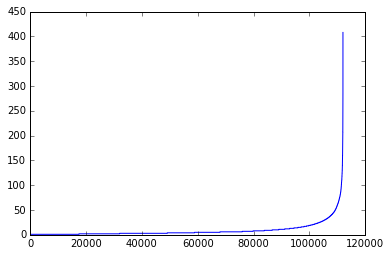

In [362]:
cdict = {}
for q in queues_id:
    for sid in q:
        if sid not in cdict:
            cdict[sid] =0
        cdict[sid] += 1        

plt.plot(sorted(v for k,v in cdict.items()))
sum(1 for sid,c in cdict.items() if c >= 5)

In [363]:
# !pip install --upgrade gensim

# import gensim

In [ ]:
sids = list(set(sid for q in queues_id for sid in q))
sid2md = dict((sid,md) for q in queues for md,sid in q)

genres = set(md[2] for q in queues_md for md in q)
idx2genre = dict(enumerate(genres))
genre2idx = dict((g,i) for i,g in enumerate(genres))

In [375]:
len(genres)

156

### Todo
- [ ] test occurrence count models - b/c window set to max sentence lenght
    - [ ] LDA
    - [ ] LSI
    - [ ] SVD

In [398]:
%%time
songid_model = gensim.models.Word2Vec(sentences=queues_id,size=64,window=200,min_count=5)

CPU times: user 57.2 s, sys: 1.53 s, total: 58.7 s
Wall time: 35.6 s


In [399]:
# %%time
# songid_model = gensim.models.LsiModel(corpus=queues_id,num_topics=200)

In [400]:
idx2sid = dict(enumerate([sid for sid in sids if sid in songid_model.wv]))
sid2idx = dict((sid,i) for i,sid in idx2sid.items())

In [401]:
tidx = np.random.rand(len(sid2idx)) < 0.8
vidx = ~tidx

# ohenc = sk.preprocessing.OneHotEncoder()

MD = np.array([sid2md[sid] for sid in sid2idx])
X = np.array([songid_model.wv[sid] for sid in sid2idx])
Y = np.array([genre2idx[sid2md[sid][2]] for sid in sid2idx])
# Yencoder = sk.preprocessing.OneHotEncoder().fit(Ycat.reshape(-1,1))
# Yencoder.transform(Ycat.reshape(-1,1)).toarray()
Xt,Xv = X[tidx],X[vidx]
Yt,Yv = Y[tidx],Y[vidx]
MDt,MDv = MD[tidx],MD[vidx]

In [402]:
Xt.shape

(42507, 64)

In [403]:
%%time
# clf = sklearn.ensemble.RandomForestClassifier(max_depth=5)
# clf.fit(Xt,Yt)
clf = sklearn.neural_network.MLPClassifier()
clf.fit(Xt,Yt)

CPU times: user 3min 29s, sys: 27 s, total: 3min 56s
Wall time: 2min 26s


In [404]:
Yhatt = clf.predict(Xt)
sum(Yhatt == Yt)/len(Yt)

0.583715623309102

In [405]:
Yhatv = clf.predict(Xv)
sum(Yhatv == Yv)/len(Yv)

0.5712020889676397

In [406]:
# gcdict = dict((g,0) for g in genre2idx)
# for i in Yv:
#     gcdict[idx2genre[i]] += 1
# print("\n".join([str((g,c)) for g,c in gcdict.items() if c]))

In [407]:
# gcdict = dict((g,0) for g in genre2idx)
# for i in Yt:
#     gcdict[idx2genre[i]] += 1
# print("\n".join([str((g,c)) for g,c in gcdict.items() if c]))

### Todo
- [ ] misclassification rate by genre -> error vs cnt in dataset
- [ ] err rate by song occurrence rate
- [ ] lda/lsi vectors
- [ ] topic modeling on genres

- on second thought - vectors seem fine - instead perform clustering

In [408]:
print("\n".join(np.random.choice(
    a=np.array([str(md)+":"+str(idx2genre[pred])+" : "+str(idx2genre[exp]) 
                for md,pred,exp in zip(MDv,Yhatv,Yv)
                if pred != exp]),
    size=50)))

['Waterloo Sunset' 'The Kinks' 'Pop' 2016]:Rock : Pop
['Crimson And Clover (Single Version)' 'Tommy James & The Shondells' 'Pop'
 2005]:Rock : Pop
['Strangelove (Alt 7" Version)' 'Depeche Mode' 'Pop' 2004]:'80s Pop : Pop
['World' 'Five for Fighting' 'Rock' 2006]:Alternative/Indie : Rock
['Rheya' 'Wild Nothing' 'Indie' 2012]:Alternative/Indie : Indie
['Simple As It Should Be' 'Tristan Prettyman' 'Folk' 2005]:Pop : Folk
['Milk and Honey' 'Toby Lightman' 'Folk' 2008]:Jazz : Folk
['You Look So Good' 'Moe Shop' None 2015]:Dance/Electronic : None
['(Dance With) The Guitar Man' 'Duane Eddy & The Rebelettes' 'Pop' 2018]:Rock : Pop
["Moi j'ai le temps" 'Serge Reggiani' 'Singer-Songwriter' 1968]:None : Singer-Songwriter
['Leave a Light On' 'Tom Walker' 'Singer-Songwriter' 2017]:Dance/Electronic : Singer-Songwriter
["Growin' Up" 'Bruce Springsteen' 'Rock' 1973]:Classic Rock : Rock
['Crying In the Chapel' 'Elvis Presley' "'50s Rock" 1967]:Rock : '50s Rock
['Careless' 'Royal Blood' 'Rock' 2014]:'10

In [118]:
np.array([(idx2genre[pred],idx2genre[exp]) 
                for pred,exp in zip(Yhatv,Yv)]).shape

(12079, 2)

In [ ]:
if all_song
    api.delete_playlist(allsongs_id)
except:
    pass
allsongs_id_new = api.create_playlist(allsongs_name)
api.add_songs_to_playlist(allsongs_id_new,list(set(ids)))